In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [64]:
TRAINING_DIR = r"/kaggle/input/brain-tumor-mri-dataset/Training"
TESTING_DIR = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [65]:
def dataset_dic(dire):
    DATASET_DIC = {}
    for folders in os.listdir(dire):
        folder_path = os.path.join(dire,folders)
        images = []
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path,image)
            images.append(image_path)
        DATASET_DIC[folders] = images
    return DATASET_DIC

    

In [66]:
DATASET_DIC = dataset_dic(TRAINING_DIR)
TESTING_DIC = dataset_dic(TESTING_DIR)

In [67]:
DATASET_DIC.keys(),TESTING_DIC.keys()

(dict_keys(['pituitary', 'notumor', 'meningioma', 'glioma']),
 dict_keys(['pituitary', 'notumor', 'meningioma', 'glioma']))

In [68]:
total_images = sum(len(images) for images in DATASET_DIC.values())
class_counts = {cls: len(images) for cls, images in DATASET_DIC.items()}

print("📊 Total images in dataset:", total_images)
print("📌 Images per class:")
for cls, count in class_counts.items():
    print(f"{cls} → {count}")

📊 Total images in dataset: 5712
📌 Images per class:
pituitary → 1457
notumor → 1595
meningioma → 1339
glioma → 1321


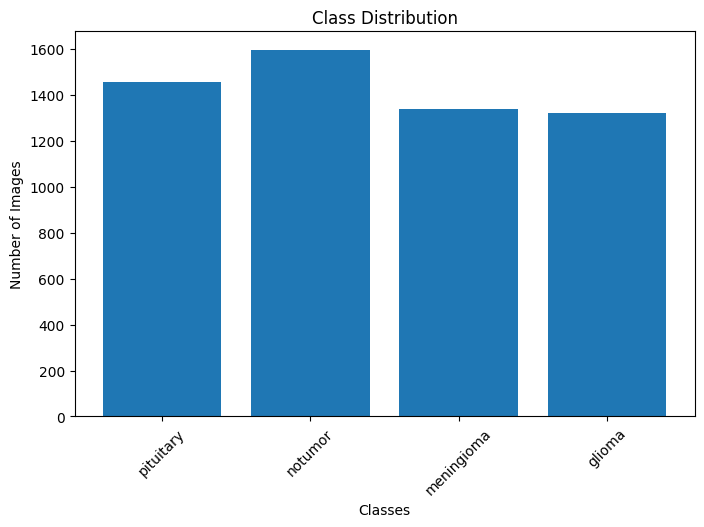

In [69]:
# 2️⃣ Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

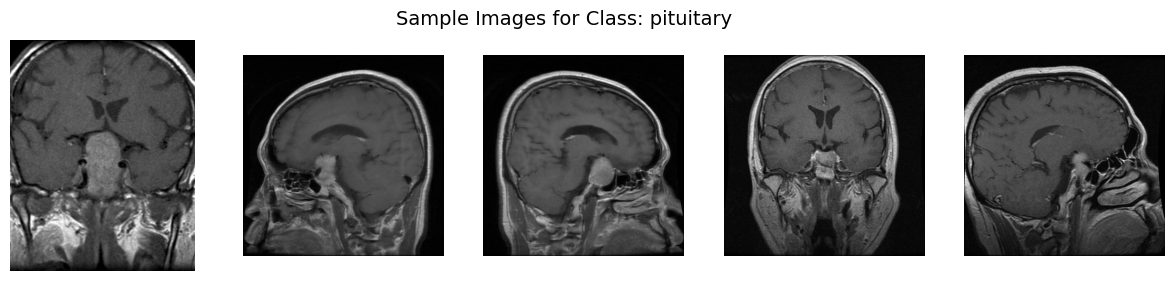

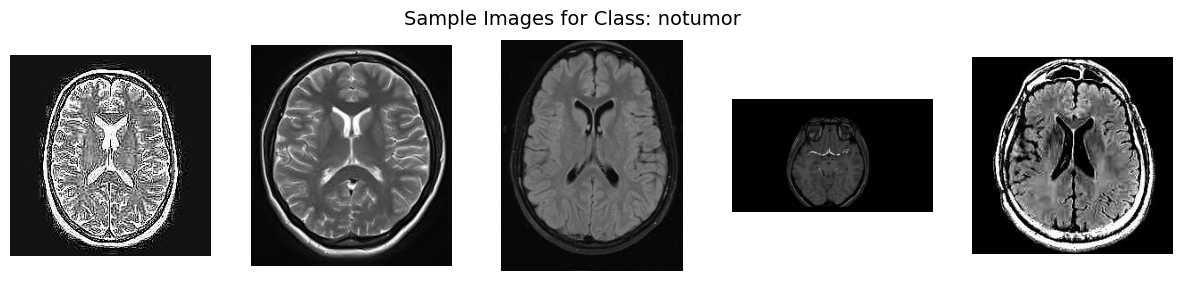

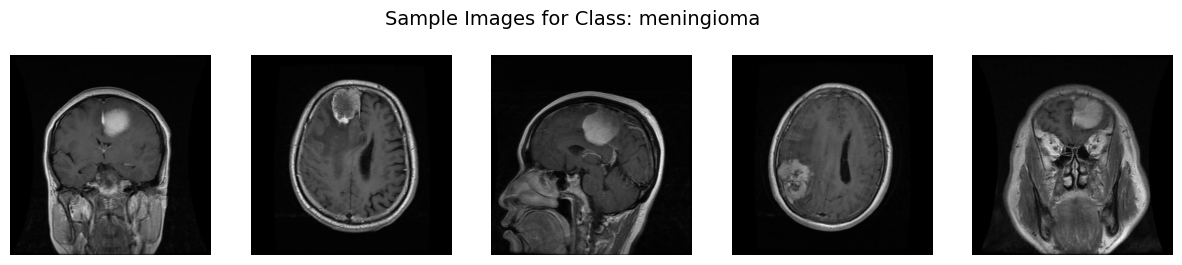

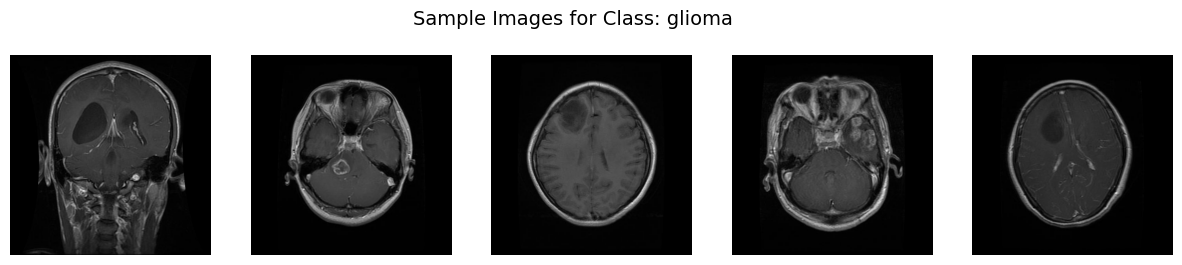

In [70]:
# 3️⃣ Display 5 sample images per class
for cls, images in DATASET_DIC.items():
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Sample Images for Class: {cls}", fontsize=14)
    
    sample_imgs = random.sample(images, min(5, len(images)))  # 5 or fewer if class has <5 images
    for i, img_path in enumerate(sample_imgs):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()


In [71]:
LABEL_MAP = {}
for pos,label in enumerate(DATASET_DIC.keys()):
    LABEL_MAP[label] = pos
LABEL_MAP

{'pituitary': 0, 'notumor': 1, 'meningioma': 2, 'glioma': 3}

In [72]:
def load_data(dic):
    X = []
    Y = []
    
    for folder,image_list in dic.items():
        for image in image_list:
            img = cv2.imread(image)
            img = cv2.resize(img,(224,224))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img = img/255.0
            X.append(img)
            Y.append(LABEL_MAP[folder])
    return np.array(X),np.array(Y)

In [73]:
X,Y = load_data(DATASET_DIC)
X_test, y_test = load_data(TESTING_DIC)

In [74]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,Y,random_state=42,test_size=0.2)

In [75]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((4569, 224, 224), (1143, 224, 224), (4569,), (1143,))

In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [77]:
# 1️⃣ Add channel dimension if grayscale
X_train = X_train.reshape(-1, 224, 224, 1)
X_val = X_val.reshape(-1, 224, 224, 1)

In [81]:



# 3️⃣ Build CNN model
def build_cnn(input_shape=(224, 224, 1), num_classes=None):

    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Convolutional Layers
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4, activation='softmax')  # Multi-class classification
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build Model
cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,817,348 (98.49 MB)

 Trainable params: 25,816,900 (98.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [79]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


In [82]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.5818 - loss: 9.7277 - val_accuracy: 0.2905 - val_loss: 11.0890
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6540 - loss: 1.6166 - val_accuracy: 0.4217 - val_loss: 4.7069
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6418 - loss: 1.1612 - val_accuracy: 0.4339 - val_loss: 1.7939
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6831 - loss: 0.8578 - val_accuracy: 0.7017 - val_loss: 0.9125
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7112 - loss: 0.8312 - val_accuracy: 0.8294 - val_loss: 0.6111
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7597 - loss: 0.6660 - val_accuracy: 0.8303 - val_loss: 0.5533
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7404 - loss: 0.6447 - val_accuracy: 0.8110 - val_loss: 0.5466
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7705 - loss: 0.5889 - val_ac

In [83]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [84]:
y_pred = cnn_model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [87]:
y_pred = [np.argmax(i) for i in y_pred]

In [89]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       300
           1       0.97      0.98      0.97       405
           2       0.92      0.61      0.73       306
           3       0.79      0.95      0.86       300

    accuracy                           0.89      1311
   macro avg       0.89      0.88      0.87      1311
weighted avg       0.89      0.89      0.88      1311



<Axes: >

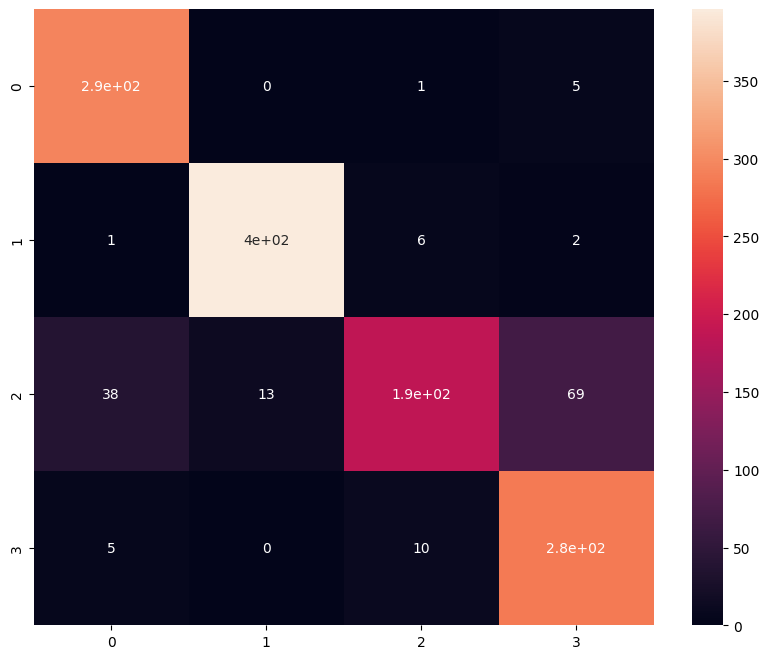

In [91]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)

In [98]:
def predict(model, image_array):
    labels = {'pituitary': 0, 'notumor': 1, 'meningioma': 2, 'glioma': 3}
    label_names = list(labels.keys())
    
    # Ensure image has correct shape: (1, 224, 224, 1)
    img = image_array.reshape(1, 224, 224, 1)  # batch dimension + channel
    
    # Normalize if needed (skip if already scaled)
    # img = img / 255.0
    
    # Predict
    prediction = model.predict(img)
    pred_class = np.argmax(prediction, axis=1)[0]
    
    return label_names[pred_class]


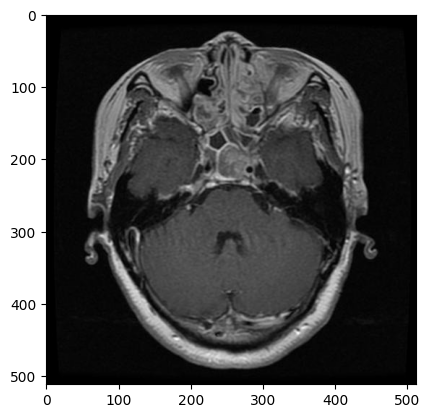

In [109]:
plt.imshow(img)

In [107]:
img = cv2.imread(TESTING_DIC['pituitary'][0])
predict(cnn_model,img)

ValueError: cannot reshape array of size 786432 into shape (1,224,224,1)

In [111]:
import cv2
import numpy as np

# Load image
import cv2
import numpy as np

img = cv2.imread(TESTING_DIC['pituitary'][0])
img_resized = cv2.resize(img, (224, 224))        # Resize to model input
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # Convert to RGB
img_normalized = img_rgb / 255.0                 # Normalize

# Ensure batch dimension
img_input = np.expand_dims(img_normalized, axis=0)  # (1, 224, 224, 3)
print("Input shape:", img_input.shape)


# 5️⃣ Make prediction
prediction = cnn_model.predict(img_input)

# 6️⃣ Get predicted class
predicted_class = np.argmax(prediction, axis=1)
print("Predicted class:", predicted_class[0])


Input shape: (1, 224, 224)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 0


In [112]:
cnn_model.save('classification_model.keras')

In [126]:
import cv2
import numpy as np

def predict_image(model, image_path):
    """
    Predict class and probabilities for a single MRI image.
    
    Args:
        model: Trained Keras model
        image_path: Path to the image
    
    Returns:
        predicted_label: String of predicted class
        probabilities: np.array of probabilities for all classes
    """
    
    # Define labels
    labels = {'pituitary': 0, 'notumor': 1, 'meningioma': 2, 'glioma': 3}
    label_names = list(labels.keys())
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # use 1 channel (grayscale)
    img_normalized = img_gray / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)  # shape: (1, 224, 224, 1)
    
    # Predict
    prediction = model.predict(img_input)
    pred_class_idx = np.argmax(prediction, axis=1)[0]
    predicted_label = label_names[pred_class_idx]
    
    # Return label and probabilities
    probabilities = prediction[0]  # shape: (num_classes,)
    
    return predicted_label, probabilities


In [127]:
image_path = TESTING_DIC['pituitary'][0]
pred_label, probs = predict_image(cnn_model, image_path)

print("Predicted Class:", pred_label)
print("Probabilities:", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class: pituitary
Probabilities: [1.0000000e+00 1.9567943e-28 2.0959531e-17 3.4818367e-35]
